In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import numpy as np
import pandas as pd
import glob
import math

from scipy.stats import norm

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [3]:
from process_data import data_uID
data = data_uID()

In [4]:
path = 'ipynb/input/train_1/event000001000'

In [5]:
data.load_training(path=path)

In [6]:
from models import HitPredictor

In [12]:
total_modules = 763

In [13]:
rnn = HitPredictor(input_dim=total_modules+1, hidden_dim=20,
               output_dim=total_modules+1,
               n_lstm_layers=1)

In [14]:
from trackml.score import score_event

In [16]:
rnn.load_state_dict(torch.load('ipynb/output/model/trained_1event_rnn_model'))

RuntimeError: Error(s) in loading state_dict for HitPredictor:
	While copying the parameter named "lstm.weight_ih_l0", whose dimensions in the model are torch.Size([80, 764]) and whose dimensions in the checkpoint are torch.Size([2048, 18729]).
	While copying the parameter named "lstm.weight_hh_l0", whose dimensions in the model are torch.Size([80, 20]) and whose dimensions in the checkpoint are torch.Size([2048, 512]).
	While copying the parameter named "lstm.bias_ih_l0", whose dimensions in the model are torch.Size([80]) and whose dimensions in the checkpoint are torch.Size([2048]).
	While copying the parameter named "lstm.bias_hh_l0", whose dimensions in the model are torch.Size([80]) and whose dimensions in the checkpoint are torch.Size([2048]).
	While copying the parameter named "fc.weight", whose dimensions in the model are torch.Size([764, 20]) and whose dimensions in the checkpoint are torch.Size([18729, 512]).
	While copying the parameter named "fc.bias", whose dimensions in the model are torch.Size([764]) and whose dimensions in the checkpoint are torch.Size([18729]).

In [33]:
max_nhits = 20
def input_hits(series):
    tensor = torch.zeros(len(series), 1, total_modules+1)
    for idx, h in enumerate(series):
        tensor[idx][0][int(h)] = 1
    return tensor
    
def check_trainingPredictor(start_hit):
    with torch.no_grad():
        input_tensor = input_hits(start_hit)
        rnn.hidden = rnn.init_hidden()
        out_hits = start_hit
        for i in range(max_nhits):
            output = rnn(input_tensor)
            topv, topi = output.topk(3)
            cand = topi[0][0]
            out_hits.append(cand.item())
            if cand == total_modules:
                # print("Hit the last hits")
                break
                
            input_tensor = input_hits([cand])
        return out_hits

In [13]:
def score_me(times):
    score_list = []
    for each in range(times):
        a_track = data.get_a_track()
        predict = np.unique(check_trainingPredictor(a_track[0]))
        true_track = pd.DataFrame(data=a_track, columns=['hit_id'])
        test_track = pd.DataFrame(data=predict, columns=['hit_id'])

        test_track['track_id'] = [0]*test_track.shape[0]

        true_track['particle_id'] = [0]*true_track.shape[0]
        true_track['weight'] = [1.0]*true_track.shape[0]
        score_list.append(score_event(true_track, test_track))
    
    return score_list

In [19]:
score_list = score_me(5000)

(array([ 1521.,     0.,     0.,     0.,     0.,   643.,   938.,   888.,
          526.,   484.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

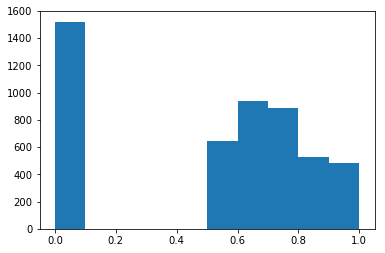

In [24]:
plt.hist(score_list)

In [25]:
score_series = pd.Series(data=score_list)

In [29]:
score_series[score_series > 0].describe()

count    3479.000000
mean        0.733081
std         0.129340
min         0.529412
25%         0.636364
50%         0.714286
75%         0.818182
max         1.000000
dtype: float64

In [27]:
score_series[].describe()

count    5000.000000
mean        0.510078
std         0.354134
min         0.000000
25%         0.000000
50%         0.642857
75%         0.769231
max         1.000000
dtype: float64

In [14]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [15]:
hits, cells, particles, truth = load_event(path)

In [16]:
from utils import get_features
from utils import make_uID
from process_data import filter_truth

In [17]:
hits_fea = get_features(hits)
eta_cut = 3.2
hits_fea = hits_fea[(hits_fea['eta'] > eta_cut) | (hits_fea['eta'] < -1*eta_cut)]
df_uID = make_uID(hits_fea)
hits_fea = pd.merge(hits_fea, df_uID, on=['volume_id', 'layer_id', 'module_id'])
truth_in = hits_fea.merge(filter_truth(truth), on=['hit_id'])

In [18]:
truth_in.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,absZ,uID,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,...,1502.5,0,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
1,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,...,1502.5,0,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
2,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,...,1502.5,0,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009
3,6,-57.068699,-8.177770,-1502.5,7,2,1,-0.037955,-0.005439,-26.061703,...,1502.5,0,108087696726949888,-57.085602,-8.189710,-1502.5,-0.401129,-0.035276,-10.46690,0.000008
4,7,-73.872299,-2.578900,-1502.5,7,2,1,-0.049107,-0.001714,-20.326769,...,1502.5,0,968286151951515648,-73.860802,-2.575860,-1502.5,-0.442662,-0.036969,-9.13010,0.000007


In [69]:
def my_score(a_track, some_hits):
    predict = np.unique(check_trainingPredictor(some_hits))
    true_track = pd.DataFrame(data=a_track, columns=['hit_id'])
    test_track = pd.DataFrame(data=predict, columns=['hit_id'])

    test_track['track_id'] = [0]*test_track.shape[0]

    true_track['particle_id'] = [0]*true_track.shape[0]
    true_track['weight'] = [1.0]*true_track.shape[0]
    return score_event(true_track, test_track)

,hit_id,uID,eta,phi,z
2,5,0,-3.859459,-2.993168,-1502.5
26,38,3,-3.859629,-2.992750,-1498.0
943,1468,107,-3.861339,-2.985009,-1302.5
970,1513,108,-3.860971,-2.984258,-1298.0
1961,3244,167,-3.862757,-2.976098,-1102.5
1990,3302,168,-3.863030,-2.975917,-1098.0
3174,5415,207,-3.863268,-2.969573,-962.5
3216,5489,208,-3.863399,-2.969996,-958.0
4581,7959,247,-3.863302,-2.963778,-822.5
4604,8013,248,-3.863569,-2.963485,-818.0


In [101]:
predicted_uIDs = np.unique(find_a_track(this_track.iloc[0]))

In [102]:
output = make_a_prediction(this_track.iloc[0])

In [103]:
output.topk(10)

(tensor([[-1.3118, -1.3399, -2.5610, -3.8051, -3.8057, -4.0918, -4.2043,
          -4.2317, -4.5394, -4.9966]]),
 tensor([[ 106,  103,    3,  395,  394,  473,  107,  654,  415,   22]]))

In [105]:
topv, topi = output.topk(10)

In [112]:
max_ll = topv[0][0]
nll2 = torch.sqrt(-2*(topv[0] - max_ll))
print(nll2)

tensor([-0.0000,  0.2369,  1.5807,  2.2331,  2.2334,  2.3580,  2.4052,
         2.4166,  2.5407,  2.7147])


In [133]:
min_eta_diff = []
for idx in range(topi.size(1)):
    df = truth_in[truth_in['uID'] == topi[0][idx]][['hit_id', 'eta']]
    df['eta'] = np.abs(df['eta'] - (-3.859459))
    min_eta_diff.append(df['eta'].min())

In [136]:
from scipy.stats import norm

In [139]:
1 - norm.cdf(1.58)

0.057053433237754136

In [134]:
min_eta_diff

[0.53235412,
 0.5539887,
 0.00016975403,
 7.1150403,
 7.1185808,
 7.0630088,
 0.0018804073,
 7.1625257,
 7.0677433,
 0.02791667]

In [141]:

for sigma,deta in zip(nll2.numpy().tolist(), min_eta_diff):
    pval = 1 - norm.cdf(sigma)
    w1 = pval / deta
    w2 = pval / (10*deta)
    print("{:.4f}, {:.4f}, {:.4f}, {:.4f}".format(pval, deta, w1, w2))

0.5000, 0.5324, 0.9392, 0.0939
0.4063, 0.5540, 0.7335, 0.0733
0.0570, 0.0002, 335.6553, 33.5655
0.0128, 7.1150, 0.0018, 0.0002
0.0128, 7.1186, 0.0018, 0.0002
0.0092, 7.0630, 0.0013, 0.0001
0.0081, 0.0019, 4.2980, 0.4298
0.0078, 7.1625, 0.0011, 0.0001
0.0055, 7.0677, 0.0008, 0.0001
0.0033, 0.0279, 0.1188, 0.0119


In [119]:
print(topi[0][2])
df_eta = truth_in[truth_in['uID'] == topi[0][2]][['hit_id', 'eta']]
df_eta['eta'] = np.abs(df_eta['eta'] - (-3.859459))


tensor(3)


In [152]:
df_eta

,hit_id,eta
23,35,0.252258
24,36,0.345351
25,37,0.454006
26,38,0.000170
27,39,0.321166
28,40,0.252157
29,41,0.329266
30,42,0.227720
31,43,0.094156
32,44,0.022766


In [128]:
df_eta['eta'].idxmin(), df_eta['eta'].min()

(26, 0.00016975403)

In [157]:
df_eta.loc[26]

hit_id    38.00000
eta        0.00017
Name: 26, dtype: float64

In [108]:
print(topi[0][3])
truth_in[truth_in['uID'] == topi[0][3]][['hit_id', 'eta']]

tensor(395)


,hit_id,eta
8532,25731,3.255581


In [88]:
def make_a_prediction(start_hit):
    with torch.no_grad():
        input_tensor = input_hits([start_hit['uID']])
        rnn.hidden = rnn.init_hidden()
        out_hits = [start_hit['uID']]
        output = rnn(input_tensor)
        return output

In [77]:
def find_a_track(start_hit):
    with torch.no_grad():
        input_tensor = input_hits([start_hit['uID']])
        rnn.hidden = rnn.init_hidden()
        out_hits = [start_hit['uID']]
        for i in range(max_nhits):
            output = rnn(input_tensor)
            topv, topi = output.topk(3)
            cand = topi[0][0]
            out_hits.append(cand.item())
            if cand == total_modules:
                # print("Hit the last hits")
                break
                
            input_tensor = input_hits([cand])
        return out_hits    

In [161]:
def make_a_prediction_with_eta_diff(all_hits, start_hit):
    with torch.no_grad():
        ref_eta = start_hit['eta']
        input_tensor = input_hits([start_hit['uID']])
        rnn.hidden = rnn.init_hidden()
        out_hits = [start_hit['uID']]
        output = rnn(input_tensor)
        
        topv, topi = output.topk(10)
        max_ll = topv[0][0]
        if topi[0][0] == total_modules:
            # that's the stop sign!
            return -1
        
        nll2 = torch.sqrt(-2*(topv[0] - max_ll))
        
        min_eta_diff = []
        for idx in range(topi.size(1)):
            df = all_hits[all_hits['uID'] == topi[0][idx]][['hit_id', 'eta']]
            df['eta'] = np.abs(df['eta'] - ref_eta)
            min_eta_diff.append((df['eta'].idxmin(), df['eta'].min()))
            
        next_hit_id = -1
        max_weight = -1
        for sigma, deta_info in zip(nll2.numpy().tolist(), min_eta_diff):
            idx, deta = deta_info
            pval = 1 - norm.cdf(sigma)
            w1 = pval / deta
            w2 = pval / math.sqrt(deta)
            if w1 > max_weight:
                max_weight = w1
                next_hit_id = idx      
            # print("{:.4f}, {:.4f}, {:.4f}, {:.4f}".format(pval, deta, w1, w2))
            
        return next_hit_id

In [21]:
def make_a_chain_with_etacuts(all_hits, start_hit):
    hit_indexs = []
    hit_uIDs = []

    with torch.no_grad():
        ref_eta = start_hit['eta']
        input_tensor = input_hits([start_hit['uID']])
        rnn.hidden = rnn.init_hidden()
        
        for i in range(max_nhits):
            output = rnn(input_tensor)
        
            topv, topi = output.topk(10)
            max_ll = topv[0][0]
            if topi[0][0] == total_modules:
                break
            if topv.size(0) < 1:
                break
                
            nll2 = torch.sqrt(-2*(topv[0] - max_ll))
        
            min_eta_diff = []
            for idx in range(topi.size(1)):
                pre_uID = topi[0][idx].item()
                df = all_hits[all_hits['uID'] == pre_uID][['hit_id', 'eta']]
                df['eta'] = np.abs(df['eta'] - ref_eta)
                try:
                    if df['eta'].idxmin() not in hit_indexs and pre_uID not in hit_uIDs:
                        min_eta_diff.append((df['eta'].idxmin(), df['eta'].min(), pre_uID))
                    else:
                        min_eta_diff.append((-1, 9999, pre_uID))
                except:
                    min_eta_diff.append((-1, 9999, pre_uID))

            next_hit_id = -1
            next_uID = -1
            max_weight = -1
            for sigma, deta_info in zip(nll2.numpy().tolist(), min_eta_diff):
                idx, deta, uID = deta_info
                pval = 1 - norm.cdf(sigma)
                w1 = pval / deta
                w2 = pval / math.sqrt(deta)
                if w1 > max_weight:
                    max_weight = w1
                    next_hit_id = idx
                    next_uID = uID
                print("\t\t{}, {}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(idx, uID, pval, deta, w1, w2))
            
            print("found next hits index", next_hit_id, "with uID:", next_uID)
            hit_indexs.append(next_hit_id)   
            hit_uIDs.append(next_uID)
            next_hit = all_hits.loc[next_hit_id]
            input_tensor = input_hits([next_hit['uID']])
            ref_eta = next_hit['eta']
        
            
    return hit_indexs, hit_uIDs

In [23]:
def make_a_chain(all_hits, start_hit):
    hit_indexs = []
    hit_uIDs = []

    with torch.no_grad():
        ref_eta = start_hit['eta']
        input_tensor = input_hits([start_hit['uID']])
        rnn.hidden = rnn.init_hidden()
        
        for i in range(max_nhits):
            output = rnn(input_tensor)
        
            topv, topi = output.topk(1)
            if topi[0][0] == total_modules:
                break
            if topv.size(0) < 1:
                break

            pre_uID = topi[0][0].item()
            df = all_hits[all_hits['uID'] == pre_uID][['hit_id', 'eta']]
            df['eta'] = np.abs(df['eta'] - ref_eta)
            
            try:
                next_hit_id = df['eta'].idxmin()
                next_uID = pre_uID
            except:
                break
            
            print("found next hits index", next_hit_id, "with uID:", next_uID)
            hit_indexs.append(next_hit_id)   
            hit_uIDs.append(next_uID)
            next_hit = all_hits.loc[next_hit_id]
            input_tensor = input_hits([next_hit['uID']])
            ref_eta = next_hit['eta']
        
            
    return hit_indexs, hit_uIDs

In [19]:
this_track = truth_in[truth_in['particle_id'] == 418835796137607168]
this_track[['hit_id', 'uID', 'eta', 'phi', 'z']]

,hit_id,uID,eta,phi,z
2,5,0,-3.859459,-2.993168,-1502.5
26,38,3,-3.859629,-2.992750,-1498.0
943,1468,107,-3.861339,-2.985009,-1302.5
970,1513,108,-3.860971,-2.984258,-1298.0
1961,3244,167,-3.862757,-2.976098,-1102.5
1990,3302,168,-3.863030,-2.975917,-1098.0
3174,5415,207,-3.863268,-2.969573,-962.5
3216,5489,208,-3.863399,-2.969996,-958.0
4581,7959,247,-3.863302,-2.963778,-822.5
4604,8013,248,-3.863569,-2.963485,-818.0


In [66]:
this_track.index

Int64Index([2, 26, 943, 970, 1961, 1990, 3174, 3216, 4581, 4604], dtype='int64')

In [55]:
def tag_a_chain(all_hits, current_hits, start_hit, track_id):
    hit_indexs = []
    hit_uIDs = []

    with torch.no_grad():
        input_tensor = input_hits([start_hit['uID']])
        ref_eta = start_hit['eta']
        rnn.hidden = rnn.init_hidden()
        all_hits.loc[all_hits['hit_id'] == start_hit['hit_id'], 'track_id'] = track_id
        
        for i in range(max_nhits):
            output = rnn(input_tensor)
        
            topv, topi = output.topk(1)
            if topi[0][0] == total_modules:
                break
            if topv.size(0) < 1:
                break

            pre_uID = topi[0][0].item()
            df = current_hits[current_hits['uID'] == pre_uID][['hit_id', 'eta']]
            df['eta'] = np.abs(df['eta'] - ref_eta)
            
            try:
                next_hit_idx = df['eta'].idxmin()
                next_uID = pre_uID
            except:
                break
            
#             print("found next hits index", next_hit_idx, "with uID:", next_uID)
            hit_indexs.append(next_hit_idx)   
            hit_uIDs.append(next_uID)
            next_hit = current_hits.loc[next_hit_idx]
            input_tensor = input_hits([next_hit['uID']])
            
            all_hits.loc[all_hits['hit_id'] == next_hit['hit_id'], 'track_id'] = track_id
            ref_eta = next_hit['eta']
        
            
    return hit_indexs, hit_uIDs

In [36]:
df = pd.DataFrame(np.arange(12).reshape(3, 4), columns=['A', 'B', 'c', 'd'])

In [40]:
new_df = df.drop([0, 1])
new_df

,A,B,c,d
2,8,9,10,11


In [69]:
new_df.loc[new_df['A'] == 8, 'B'] = 9.9
new_df.index[0]

2

In [72]:
truth_submission.shape

(17599, 25)

In [70]:
truth_cp1 = truth_in.copy()
truth_submission = truth_in.copy()

In [71]:
track_id = 1
while truth_cp1.shape[0] > 0:
    # find a track
    hit_indexs, hit_uIDs = tag_a_chain(truth_submission, truth_cp1, truth_cp1.iloc[0], track_id)
    truth_cp1 = truth_cp1.drop(truth_cp1.index[0]+hit_indexs)
    track_id += 1

KeyboardInterrupt: 

		922, 106, 0.5000, 0.5324, 0.9392, 0.6853
		902, 103, 0.4741, 0.5540, 0.8557, 0.6369
		26, 3, 0.2886, 0.0002, 1702.3099, 22.1638
		39, 4, 0.0065, 0.5090, 0.0128, 0.0091
		12056, 512, 0.0061, 7.0701, 0.0009, 0.0023
		6522, 298, 0.0059, 0.0399, 0.1479, 0.0296
		60, 6, 0.0037, 0.5222, 0.0071, 0.0051
		15311, 603, 0.0030, 7.1345, 0.0004, 0.0011
		726, 83, 0.0029, 0.0053, 0.5456, 0.0398
		8183, 355, 0.0026, 0.1765, 0.0150, 0.0063
found next hits index 26 with uID: 3
		922, 106, 0.5000, 0.5325, 0.9389, 0.6852
		943, 107, 0.0199, 0.0017, 11.6068, 0.4801
		39, 4, 0.0009, 0.5092, 0.0018, 0.0013
		1885, 162, 0.0007, 0.6530, 0.0010, 0.0008
		-1, 3, 0.0006, 9999.0000, 0.0000, 0.0000
		1908, 164, 0.0006, 0.6532, 0.0009, 0.0007
		902, 103, 0.0004, 0.5542, 0.0008, 0.0006
		-1, 405, 0.0003, 9999.0000, 0.0000, 0.0000
		60, 6, 0.0002, 0.5224, 0.0005, 0.0003
		972, 109, 0.0002, 0.6400, 0.0004, 0.0003
found next hits index 943 with uID: 107
		1908, 164, 0.5000, 0.6549, 0.7635, 0.6178
		-1, 107, 0.1580, 9

([26, 943, 970, 1912, 3072, 4436, 4467, 5968],
 [3, 107, 108, 165, 204, 243, 244, 283])

In [27]:
res = make_a_chain(truth_in, this_track.iloc[0])
res

found next hits index 922 with uID: 106
found next hits index 1908 with uID: 164
found next hits index 3082 with uID: 204
found next hits index 4483 with uID: 244
found next hits index 5987 with uID: 283
found next hits index 6006 with uID: 284
found next hits index 7341 with uID: 323
found next hits index 7341 with uID: 323


([922, 1908, 3082, 4483, 5987, 6006, 7341, 7341],
 [106, 164, 204, 244, 283, 284, 323, 323])

		922, 106, 0.5000, 0.5324, 0.9392, 0.6853
		902, 103, 0.4741, 0.5540, 0.8557, 0.6369
		39, 4, 0.0065, 0.5090, 0.0128, 0.0091
		12056, 512, 0.0061, 7.0701, 0.0009, 0.0023
		6522, 298, 0.0059, 0.0399, 0.1479, 0.0296
		60, 6, 0.0037, 0.5222, 0.0071, 0.0051
		15311, 603, 0.0030, 7.1345, 0.0004, 0.0011
		726, 83, 0.0029, 0.0053, 0.5456, 0.0398
		8183, 355, 0.0026, 0.1765, 0.0150, 0.0063
		10788, 480, 0.0019, 7.0601, 0.0003, 0.0007
found next hits index 922 with uID: 106
		1908, 164, 0.5000, 0.1207, 4.1434, 1.4393
		1885, 162, 0.1161, 0.1204, 0.9638, 0.3345
		944, 107, 0.0405, 0.0224, 1.8107, 0.2709
		-1, 106, 0.0076, 9999.0000, 0.0000, 0.0001
		-1, 762, 0.0048, 9999.0000, 0.0000, 0.0000
		2501, 186, 0.0035, 0.0059, 0.5952, 0.0456
		3780, 225, 0.0032, 0.0087, 0.3701, 0.0345
		3022, 202, 0.0023, 0.0344, 0.0665, 0.0123
		64, 6, 0.0022, 0.0003, 7.0552, 0.1254
		9929, 455, 0.0021, 6.5354, 0.0003, 0.0008
found next hits index 64 with uID: 6
		1885, 162, 0.5000, 0.1208, 4.1404, 1.4388
		944, 107,

/Users/xju/miniconda3/envs/rlpy3p6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/Users/xju/miniconda3/envs/rlpy3p6/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


		3089, 205, 0.5000, 0.0043, 116.6380, 7.6367
		1936, 166, 0.0226, 0.1172, 0.1925, 0.0659
		4439, 243, 0.0036, 0.0339, 0.1063, 0.0196
		1908, 164, 0.0024, 0.1210, 0.0201, 0.0070
		9387, 437, 0.0020, 6.5328, 0.0003, 0.0008
		4480, 244, 0.0013, 0.0440, 0.0293, 0.0061
		-1, 165, 0.0010, 9999.0000, 0.0000, 0.0000
		6012, 284, 0.0009, 0.0603, 0.0152, 0.0037
		3081, 204, 0.0008, 0.0054, 0.1426, 0.0105
		4718, 251, 0.0008, 0.0039, 0.1991, 0.0124
found next hits index 3089 with uID: 205
		4480, 244, 0.5000, 0.0397, 12.5871, 2.5087
		4510, 245, 0.1029, 0.0153, 6.7368, 0.8325
		4439, 243, 0.0793, 0.0296, 2.6745, 0.4605
		6012, 284, 0.0058, 0.0645, 0.0904, 0.0230
		4533, 246, 0.0022, 0.0047, 0.4644, 0.0320
		3118, 206, 0.0020, 0.0045, 0.4427, 0.0296
		-1, 762, 0.0018, 9999.0000, 0.0000, 0.0000
		13233, 540, 0.0018, 6.5651, 0.0003, 0.0007
		5974, 283, 0.0009, 0.0304, 0.0309, 0.0054
		7361, 323, 0.0007, 0.0316, 0.0228, 0.0041
found next hits index 4480 with uID: 244
		4515, 245, 0.5000, 0.0010, 519

In [143]:
this_track = truth_in[truth_in['particle_id'] == 418835796137607168]
this_track[['hit_id', 'uID', 'eta', 'phi', 'z']]

,hit_id,uID,eta,phi,z
2,5,0,-3.859459,-2.993168,-1502.5
26,38,3,-3.859629,-2.992750,-1498.0
943,1468,107,-3.861339,-2.985009,-1302.5
970,1513,108,-3.860971,-2.984258,-1298.0
1961,3244,167,-3.862757,-2.976098,-1102.5
1990,3302,168,-3.863030,-2.975917,-1098.0
3174,5415,207,-3.863268,-2.969573,-962.5
3216,5489,208,-3.863399,-2.969996,-958.0
4581,7959,247,-3.863302,-2.963778,-822.5
4604,8013,248,-3.863569,-2.963485,-818.0


In [144]:
this_track.iloc[0]

hit_id         5.000000e+00
x             -6.267360e+01
y             -9.371200e+00
z             -1.502500e+03
volume_id      7.000000e+00
layer_id       2.000000e+00
module_id      1.000000e+00
x2            -4.167582e-02
y2            -6.231531e-03
z2            -2.370983e+01
r2             6.337033e+01
r              1.503836e+03
eta           -3.859459e+00
phi           -2.993168e+00
absZ           1.502500e+03
uID            0.000000e+00
particle_id    4.188358e+17
tx            -6.265940e+01
ty            -9.375040e+00
tz            -1.502500e+03
tpx           -2.818060e-01
tpy           -2.348700e-02
tpz           -6.573180e+00
weight         8.873380e-06
Name: 2, dtype: float64

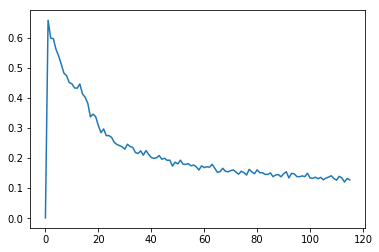

In [186]:
loss_list = np.load('loss_list')
plt.plot(loss_list)

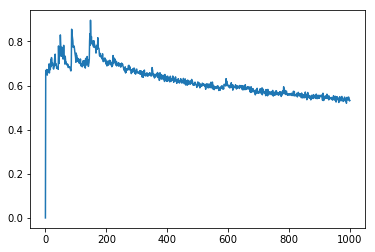

In [4]:
loss_list = np.load('loss_list_full_model')
plt.plot(loss_list)

In [3]:
m = nn.MaxPool1d(3, stride=2)
input = torch.randn(20, 16, 30)
output = m(input)

In [5]:
output.shape

torch.Size([20, 16, 14])